In [11]:
import rasterio as rio
import geopandas as gpd
import sys
sys.path.insert(1, '../src')
import data_sources as dts

from pathlib import Path

from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import numpy as np

In [2]:
country = 'Mexico'
city = 'Mérida'

data_path = Path('../data')
cache_path = data_path / f'cache/{country}-{city}'

cities_uc = gpd.read_file(data_path / 'output/cities/cities_uc.gpkg')
cities_fua = gpd.read_file(data_path / 'output/cities/cities_fua.gpkg')

uc = cities_uc.loc[(cities_uc.country == country) &
                   (cities_uc.city == city)]
fua = cities_fua.loc[(cities_fua.country == country) &
                   (cities_fua.city == city)]

bbox = dts.get_roi(fua, buff=10, buff_type='km').geometry[0]

In [24]:
def tif_from_bbox_s3(s3_path, local_path, bbox, bucket='tec-expansion-urbana-p', nodata_to_zero=False):
    subset, profile = np_from_bbox_s3(s3_path, bbox, bucket, nodata_to_zero)
    
    with rio.open(local_path, 'w', **profile) as dst:
        dst.write(subset)

In [25]:
def np_from_bbox_s3(s3_path, bbox, bucket='tec-expansion-urbana-p', nodata_to_zero=False):
    url = f'http://{bucket}.s3.amazonaws.com/{s3_path}'
    
    with rio.open(url) as src:
        profile = src.profile.copy()
        transform = profile['transform']
        window = rio.windows.from_bounds(*bbox.bounds, transform).round_lengths().round_offsets()
        # The transform is specified as (dx, rot_x, x_0 , rot_y, dy, y0)
        new_transform = src.window_transform(window)
        profile.update({
            'height': window.height,
            'width': window.width,
            'transform': new_transform})
        subset = src.read(window=window)
    if nodata_to_zero:
        subset[subset == profile['nodata']] = 0
        
    return subset, profile

In [26]:
def gisa_yearly_s3(bbox, data_path, s3_path='GISA_v02_COG.tif', bucket='tec-expansion-urbana-p'):
    # Get gisa in original encoding
    gisa, profile = np_from_bbox_s3(s3_path, bbox, bucket)
    
    # Save original encoding
    with rio.open(data_path / 'gisa_all.tif', 'w', **profile) as dst:
        dst.write(gisa)
    
    # Extract yearly tifs
    gisa_dict = {1972: 1, 1978: 2} | {year: val + 3 for val, year in enumerate(range(1985, 2020))}
    for year, pix_val in gisa_dict.items():
        gisa_binary = np.logical_and(0 < gisa, gisa <= pix_val).astype('uint8')
        with rio.open(data_path / f'gisa_{year}.tif', 'w', **profile) as dst:
            dst.write(gisa_binary)

In [27]:
def landscan_yearly_s3(bbox, data_path, s3_dir='landscan_global', bucket='tec-expansion-urbana-p'):
    for year in range(2000, 2021):
        tif_from_bbox_s3(f'{s3_dir}/landscan-global-{year}.tif', data_path / f'landscan_{year}.tif', bbox, bucket, nodata_to_zero=True)

In [12]:
gisa_yearly_s3(bbox, Path('.'))

In [28]:
landscan_yearly_s3(bbox, Path('.'))

Warning 1: HTTP response code on http://tec-expansion-urbana-p.s3.amazonaws.com/landscan_global/landscan-global-2000.tif.msk: 403
Warning 1: HTTP response code on http://tec-expansion-urbana-p.s3.amazonaws.com/landscan_global/landscan-global-2000.tif.MSK: 403
Warning 1: HTTP response code on http://tec-expansion-urbana-p.s3.amazonaws.com/landscan_global/landscan-global-2001.tif.msk: 403
Warning 1: HTTP response code on http://tec-expansion-urbana-p.s3.amazonaws.com/landscan_global/landscan-global-2001.tif.MSK: 403
Warning 1: HTTP response code on http://tec-expansion-urbana-p.s3.amazonaws.com/landscan_global/landscan-global-2002.tif.msk: 403
Warning 1: HTTP response code on http://tec-expansion-urbana-p.s3.amazonaws.com/landscan_global/landscan-global-2002.tif.MSK: 403
Warning 1: HTTP response code on http://tec-expansion-urbana-p.s3.amazonaws.com/landscan_global/landscan-global-2003.tif.msk: 403
Warning 1: HTTP response code on http://tec-expansion-urbana-p.s3.amazonaws.com/landscan_g

In [1]:
import rioxarray as rxr

In [2]:
landscan = rxr.open_rasterio('landscan_2020.tif')

In [33]:
landscan.values[landscan.values < 0] = 0

In [3]:
landscan

<xarray.DataArray (band: 1, y: 66, x: 65)>
array([[[ 0,  0, ...,  0,  0],
        [ 0,  0, ...,  0,  0],
        ...,
        [ 2,  5, ...,  0,  7],
        [ 7, 15, ...,  1,  1]]], dtype=int32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -89.87 -89.86 -89.85 ... -89.35 -89.35 -89.34
  * y            (y) float64 21.3 21.3 21.29 21.28 ... 20.79 20.78 20.77 20.76
    spatial_ref  int64 0
Attributes:
    _FillValue:    -2147483647.0
    scale_factor:  1.0
    add_offset:    0.0

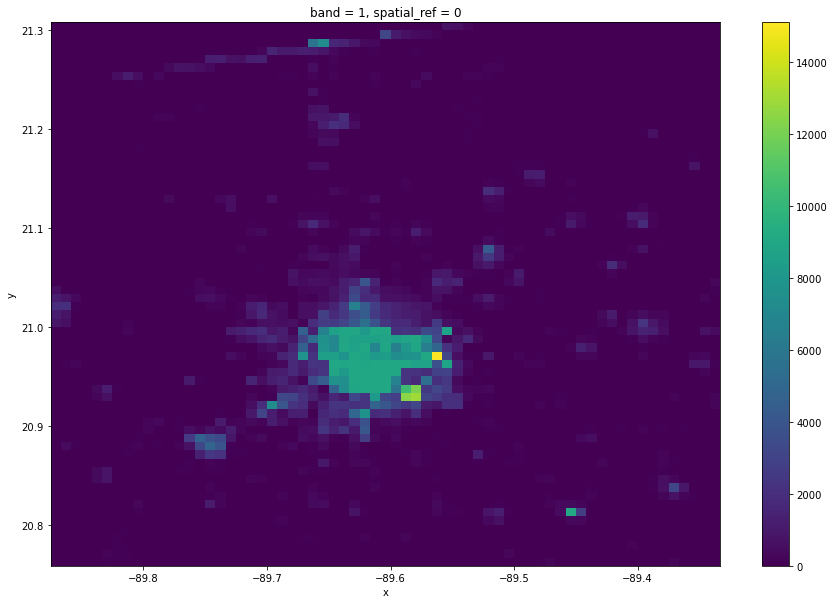

In [24]:
landscan.plot(figsize=(15,10))

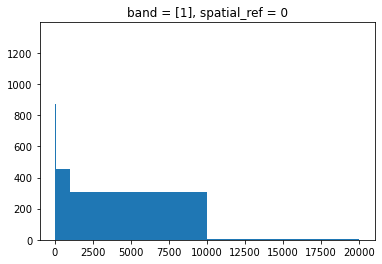

In [20]:
landscan.plot.hist(bins=[1,10,100, 1000, 10000, 20000]);

In [5]:
landscan.max()

<xarray.DataArray ()>
array(15109, dtype=int32)
Coordinates:
    spatial_ref  int64 0

In [6]:
landscan.sum()

<xarray.DataArray ()>
array(1417383)
Coordinates:
    spatial_ref  int64 0